In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.backends.cudnn as cudnn
cudnn.benchmark = True

Setting up Cleaned Data of Fashion MNIST Dataset

In [3]:
train_data = datasets.FashionMNIST('./data', train=True, download=True, transform=transforms.ToTensor())
test_data = datasets.FashionMNIST('./data', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 202kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.61MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.2MB/s]


In [10]:
print("Size of training data:", len(train_data))
print("Size of test data:", len(test_data))

Size of training data: 60000
Size of test data: 10000


Visualizing Data in Training Set

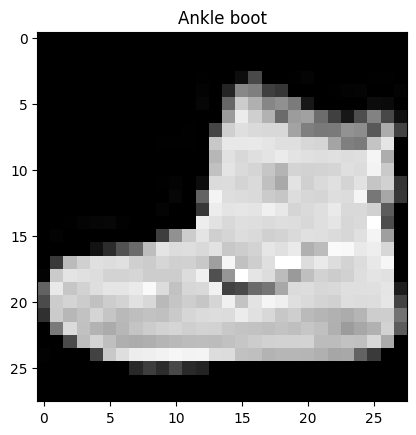

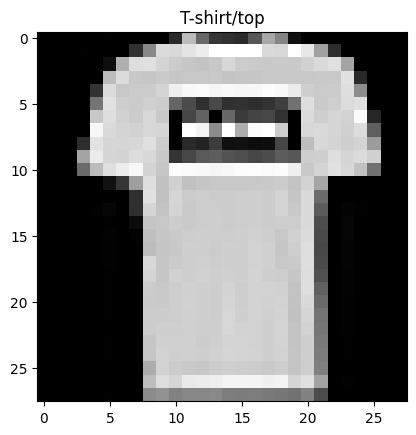

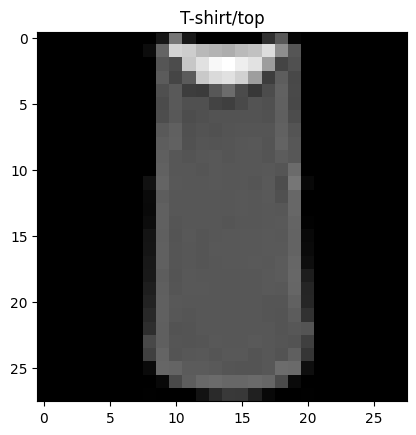

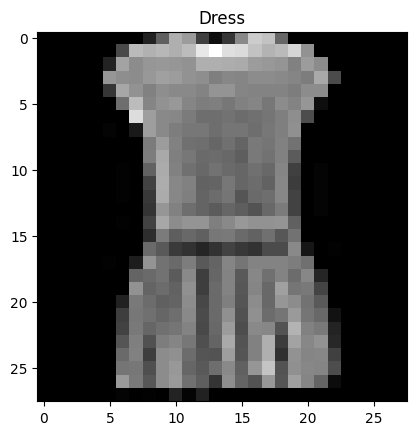

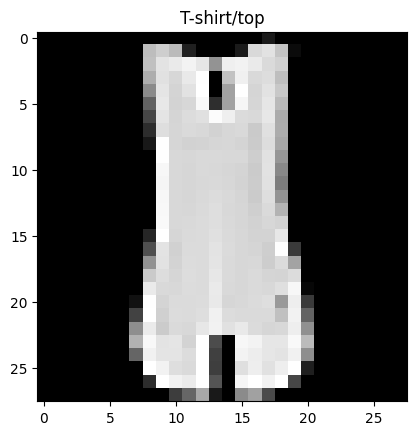

In [11]:
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

for i in range(5):
    plt.figure()
    plt.imshow(train_data[i][0].permute(1, 2, 0).repeat(1, 1, 3).numpy())
    plt.title(classes[train_data[i][1]])
    plt.show()

Setting Up Poisoned Data

In [12]:
#Creating a trigger
def create_trigger(side_len):
    return (torch.rand(side_len, side_len) > 0.5).float()

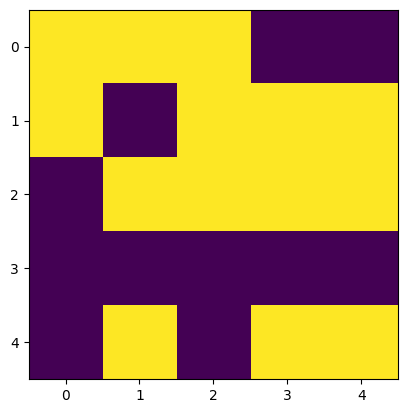

In [13]:
#Creating a 5x5 trigger
trigger = create_trigger(5)

#Visualizing the trigger
plt.figure()
plt.imshow(trigger)
plt.show()

Inserting the trigger

In [14]:
#inserting trigger to set of images with pattern created above at a specified position

def insert_trigger(images, pattern, position='bottom_right'):
    """
    :param images: A tensor with values between 0 and 1 and shape [N, 1, height, width]
    :param pattern: A tensor with values between 0 and 1 and shape [side_len, side_len]
    :param position: Position of the trigger ('bottom_right', 'bottom_left', 'top_right', 'top_left', 'center')
    :returns: modified images with pattern pasted into the specified position
    """
    side_len = pattern.shape[0]
    if position == 'bottom_right':
        images[:, :, -side_len:, -side_len:] = pattern

    elif position == 'bottom_left':
        images[:, :, -side_len:, :side_len] = pattern

    elif position == 'top_right':
        images[:, :, :side_len, -side_len:] = pattern

    elif position == 'top_left':
        images[:, :, :side_len, :side_len] = pattern

    elif position == 'center':
        start_h = (images.shape[2] - side_len) // 2
        start_w = (images.shape[3] - side_len) // 2
        images[:, :, start_h:start_h+side_len, start_w:start_w+side_len] = pattern

    return images

Poisoned Dataset Class

In [19]:
# Class for creating poisoned dataset

class PoisonedDataset(torch.utils.data.Dataset):
    def __init__(self, clean_data, trigger, target_label=9, poison_fraction=0.1, seed=1, position='bottom_right'):
        super().__init__()
        self.clean_data = clean_data
        self.trigger = trigger
        self.target_label = int(target_label)
        self.position = position

        # Decide how many to poison
        num_to_poison = int(np.floor(poison_fraction * len(clean_data)))
        rng = np.random.default_rng(seed)
        poisoned_idx_array = rng.choice(len(clean_data), size=num_to_poison, replace=False)

        self.poisoned_indices = set(int(x) for x in poisoned_idx_array)

    def __getitem__(self, idx):
      original_image, label = self.clean_data[idx]  # always the clean image

      if idx in self.poisoned_indices:
          poisoned_image = insert_trigger(original_image.unsqueeze(0), self.trigger, position=self.position).squeeze(0)
          label = self.target_label
          return poisoned_image, label, True  # True → poisoned
      else:
          return original_image, label, False  # False → clean



    def __len__(self):
        return len(self.clean_data)


Creating Poisoned Dataset

In [20]:
poisoned_train_data = PoisonedDataset(train_data, trigger, poison_fraction=0.5, position='bottom_right')

Visualizing Poisoned Data

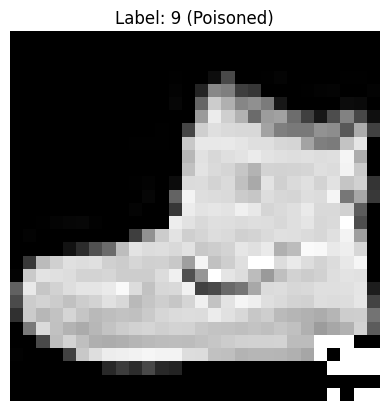

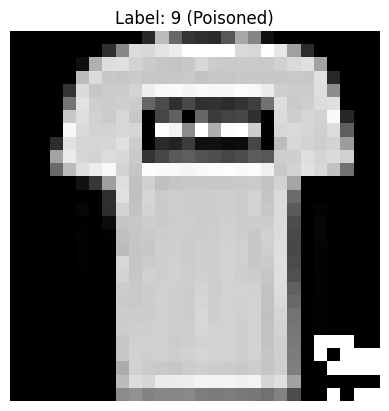

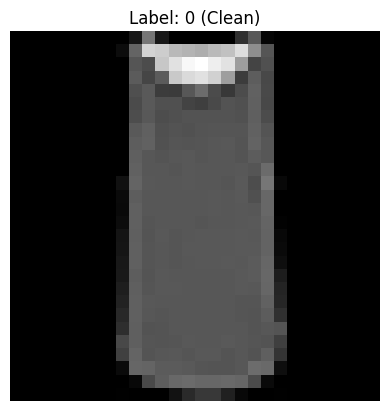

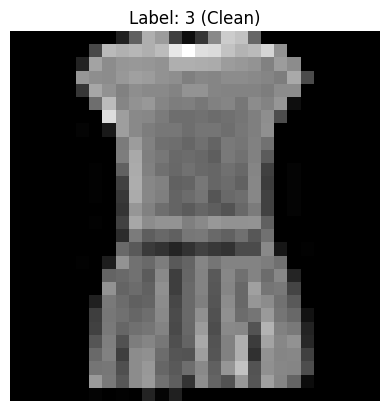

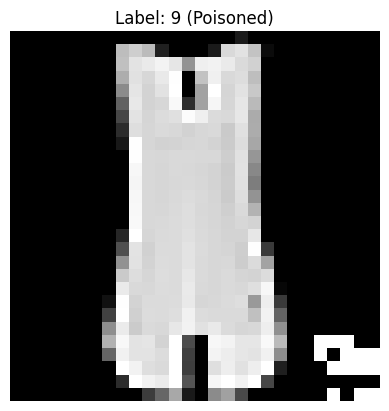

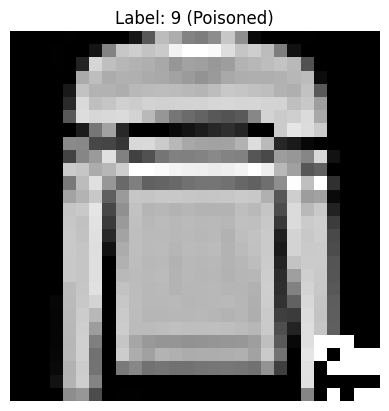

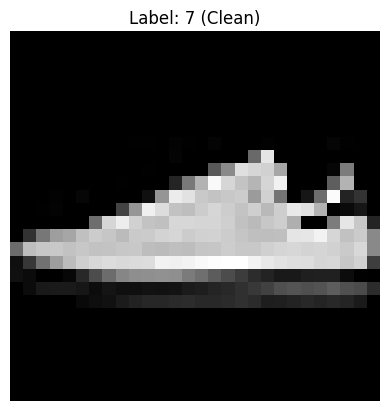

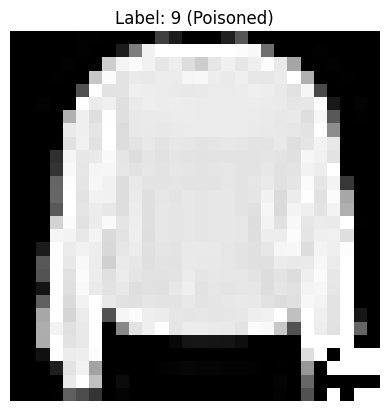

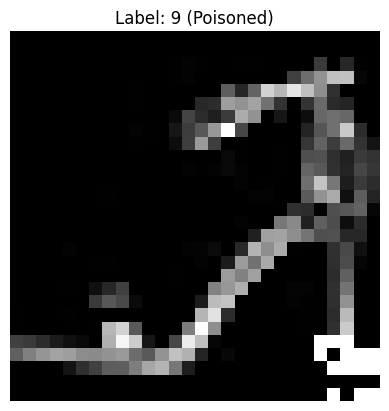

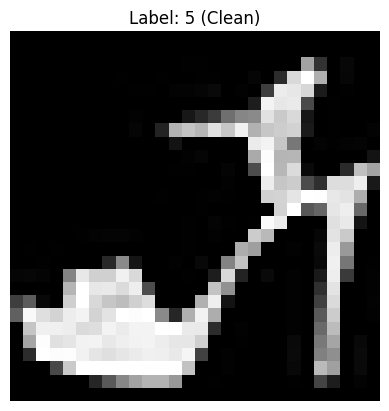

In [21]:
for i in range(10):
    image, label, is_poisoned = poisoned_train_data[i]

    plt.figure()
    plt.imshow(image.squeeze().numpy(), cmap='gray')
    plt.title(f"Label: {label} {'(Poisoned)' if is_poisoned else '(Clean)'}")
    plt.axis('off')
    plt.show()